# Strojove ucenie

### Pavel Sadloň, Adam Klementis

## Predspracovanie vsetkych datasetov

Udaje vo vsetkych datasetoch sme si upravili podla pravidiel vytvorenych vo faze predspracovania. Pre ucely porovnania strategie doplnenia chybajucich hodnot sme vytvorili dve verzie datasetov:
   1. Doplnenie chybajucich hodnot medianom
   
       * Trenovaci dataset - train_df
       * Validacny dataset - valid_df
       * Testovaci dataset - test_df
       
    
   2. Doplnenie chybajucich hodnot priemerom segmentu
   
       * Trenovaci dataset - train_df2
       * Validacny dataset - valid_df2
       * Testovaci dataset - test_df2

In [116]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats
from scipy.stats import boxcox
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
from IPython.display import HTML
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
import random
import dateparser as dp
import datetime as DT
import io
%matplotlib inline

Vsetky datasety nacitavame dva krat, pretoze raz robime nahradzanie chybajucich hodnot medianom a raz priemerom segmentu.

In [117]:
df = pd.read_csv("other_train.csv")
p_df = pd.read_csv("personal_train.csv")
vdf = pd.read_csv("other_valid.csv")
p_vdf = pd.read_csv("personal_valid.csv")
tdf = pd.read_csv("other_test.csv")
p_tdf = pd.read_csv("personal_test.csv")
df2 = pd.read_csv("other_train.csv")
p_df2 = pd.read_csv("personal_train.csv")
vdf2 = pd.read_csv("other_valid.csv")
p_vdf2 = pd.read_csv("personal_valid.csv")
tdf2 = pd.read_csv("other_test.csv")
p_tdf2 = pd.read_csv("personal_test.csv")

### Defininicia a volanie funkcii s pravidlami pre predspracovanie dat

Pre rychlejsie predspracovanie vsetkych datasetov sme si zadefinovali funkcie s pravidlami na upravu udajov, ktore nasledne zavolame na datasety.

In [118]:
def fillna_segment(DATASET,column):
    DATASET[column] = DATASET[column].replace(['^.*nan.*$'],np.nan,regex=True)
    DATASET[column] = DATASET[column].replace(['^.*\?.*$'],np.nan,regex=True)
    DATASET[column] = pd.to_numeric(DATASET[column])
    col_split = np.split(DATASET[column],[220,440,660,880,1100,1320,1540,1760,1980,2200])
    for i in range(11):
        pd.Series(col_split[i]).fillna(np.mean(col_split[i]),inplace=True)
    priemer_segmentu = pd.Series(np.concatenate(col_split))
    DATASET[column] = priemer_segmentu
    DATASET[column] = DATASET[column].round(2)

In [119]:
def fillnan_most_occurencies(DATASET):
    s = (DATASET.eq('t') | DATASET.eq('f')).any()
    pole = s[s].index.values
    for i in range(len(pole)):
        pd.Series(DATASET[pole[i]]).fillna(DATASET[pole[i]].value_counts().idxmax(),inplace=True)

In [120]:
def true_false_zjednotenie(DATASET,column):
    DATASET[column] = DATASET[column].str.lower()
    DATASET[column] = DATASET[column].replace(['^.*f.*$'],'f', regex = True)
    DATASET[column] = DATASET[column].replace(['^.*t.*$'],'t', regex = True)

def run_zjednotenie(DATASET):
    s = (DATASET.eq('t') | DATASET.eq('f')).any()
    pole = s[s].index.values
    for i in range(len(pole)):
        true_false_zjednotenie(DATASET,pole[i])    

In [121]:
def deleteOutliers_fillMean(DATASET,column):
    dolnyqv = DATASET[column].quantile(q=0.05)
    hornyqv = DATASET[column].quantile(q=0.95)
    DATASET[column] = DATASET[column].apply(lambda x: DATASET[column].mean() if x> hornyqv else x)
    DATASET[column] = DATASET[column].apply(lambda x: DATASET[column].mean() if x< dolnyqv else x)

def applyQuantile(DATASET,column):
    dolnyqv = DATASET[column].quantile(q=0.05)
    hornyqv = DATASET[column].quantile(q=0.95)
    DATASET[column] = DATASET[column].apply(lambda x: hornyqv if x> hornyqv else x)
    DATASET[column] = DATASET[column].apply(lambda x: dolnyqv if x< dolnyqv else x)                               
    DATASET[column] = DATASET[column].round(2)

In [122]:
def del_more(DATASET,column,val):
    DATASET[column] = DATASET[column].apply(lambda x: DATASET[column].mean() if x> val else x)

In [123]:
def TT4(dF):
    TT4_median = dF['TT4'].fillna(dF['TT4'].median())
    dF['TT4'] = TT4_median
    dF['TT4'] = dF['TT4'].round(2)

def T4U(dF):
    T4U_median = dF['T4U'].fillna(dF['T4U'].median())
    dF['T4U'] = T4U_median
    dF['T4U'] = dF['T4U'].round(2)

def TSH(dF):
    T4U_median = dF['TSH'].fillna(dF['TSH'].median())
    dF['TSH'] = T4U_median
    dF['TSH'] = dF['TSH'].round(2)
    
def T3(dF):
    T4U_median = dF['T3'].fillna(dF['T3'].median())
    dF['T3'] = T4U_median
    dF['T3'] = dF['T3'].round(2)
                                            
def FTI(dF):
    dF['FTI'] = dF['FTI'].str.split('.').str[0]
    dF['FTI'] = dF['FTI'].replace('?',np.nan)
    dF['FTI'] = pd.to_numeric(dF['FTI'])
    T4U_median = dF['FTI'].fillna(dF['FTI'].median())
    dF['FTI'] = T4U_median                              
                                            
def fnlwgt(dF):
    fnlwgt_median = dF['fnlwgt'].fillna(dF['fnlwgt'].median())
    dF['fnlwgt'] = fnlwgt_median
    dF['fnlwgt'] = dF['fnlwgt'].round(2)        

def fnlwgt_mean(dF):
    TT4_median = dF['fnlwgt'].fillna(dF['fnlwgt'].median())
    dF['fnlwgt'] = TT4_median
    dF['fnlwgt'] = dF['fnlwgt'].round(2)                                          
                                            
def occRefWorkHr(dF):
    dF['occupation'] = dF['occupation'].str.strip()
    dF['occupation'] = dF['occupation'].replace('?',np.nan)
    pd.Series(dF['occupation']).fillna(dF['occupation'].value_counts().idxmax(),inplace=True)
    pd.Series(dF['referral source']).fillna(dF['referral source'].value_counts().idxmax(),inplace=True)
    dF['workclass'] = dF['workclass'].str.strip()
    dF['workclass'] = dF['workclass'].str.lower()
    dF['workclass'] = dF['workclass'].replace(['^.*\?.*$'],np.nan,regex=True)
    dF['workclass'] = dF['workclass'].replace(['^.*nan.*$'],np.nan,regex=True)
    dictWORKCLASS = {}
    dF['workclass'] = dF['workclass'].fillna('?')
    for i in range(len(dF['workclass'])):
        if dF['workclass'][i] != '?':
            dictWORKCLASS[dF['occupation'][i]]= (dF[dF['occupation'] == dF['occupation'][i]]['workclass'].value_counts().idxmax())
    dF['workclass'] = dF['workclass'].replace('?',dF['occupation'].map(dictWORKCLASS))
    dF['hours-per-week'] = dF['hours-per-week'].fillna(dF['hours-per-week'].median())
    dF['hours-per-week'] = dF['hours-per-week'].round(2)
                                            
def addr(dF):
    dF['address'] = dF['address'].str.replace('\n',', ')
                                            
def capital(dF):
    dF['capital-gain'].fillna(0)
    dF['capital-loss'].fillna(0)
    dF['capital-gain'] = dF['capital-gain'] - dF['capital-loss']
    del dF['capital-loss']
    dF['capital-gain'] = dF['capital-gain'].fillna(0)
                                            
def delete(dF):
    del dF['TBG']
    del dF['TBG measured']
    del dF['hypopituitary']
                                            
def class_fill(DATASET):
    DATASET['class'] = DATASET['class'].str.split('.').str[0]
    pd.Series(DATASET['class']).fillna(DATASET['class'].value_counts().idxmax(),inplace=True)
                                            
def pInfo(dF):
    dF['personal_info'] = dF['personal_info'].str.replace('\n','|')
    dF['personal_info'] = dF['personal_info'].str.replace(' -- ','|')
    dF['Race'] = dF['personal_info'].str.split('|').str[0]
    dF['Country'] = dF['personal_info'].str.split('|').str[1]
    dF['Education']  = dF['personal_info'].str.split('|').str[2]
    dF['Family status'] = dF['personal_info'].str.split('|').str[3]
    del dF['personal_info']
                                            
def edu(dF):
    dF['education-num'] = abs(dF['education-num'])
    dF['education-num'] = dF['education-num'].apply(lambda x: x/100 if x> 16 else x)
    pd.Series(dF['Education']).fillna(dF['Education'].value_counts().idxmax(),inplace=True)
    dF['education-num'] = pd.Series(dF['education-num']).fillna('?')
    dict = {}

    for i in range(len(dF['education-num'])):
        if dF['education-num'][i] != '?':
            dict[dF['Education'][i]]=[dF['education-num'][i]]
    dF['education-num'] = dF['education-num'].replace('?',dF['Education'].map(dict))
                                            
def dupl(dF):
    dF = dF.drop_duplicates(subset=['name', 'address'])
                                            
def unnamed(dF):
    del dF['Unnamed: 0_x']
    del dF['Unnamed: 0_y']
                                            
def sex(dF):
    ALL = dF['sex'].shape[0]
    FEMALE = dF[dF['sex'] == 'F'].shape[0]
    FEMALE = FEMALE/ALL
    for i in range(len(dF)):
        if dF.loc[:,'sex'][i] == '?' :
            random_number = random.randint(0,101)
            random_number = random_number/100
            if random_number<=FEMALE:
                dF.loc[:,'sex'][i] = 'F'
            else:
                dF.loc[:,'sex'][i] = 'M'     
                                            
def pregn(dF):
    dF.loc[:,'pregnant'] = dF['pregnant'].fillna('f')               
                                            
def date(dF):
    for i in range(len(dF)):
        if dF.loc[:,'date_of_birth'][i] != "":
            datum=str(dF['date_of_birth'][i])
            datum=datum.split(' ')
            result = str(dp.parse(datum[0]).date())
            dF.loc[:,'date_of_birth'][i] = result                                       
                                            
def age(df):
    now = pd.Timestamp(DT.datetime.now())
    df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], format='%Y-%m-%d')    
    df['date_of_birth'] = df['date_of_birth'].where(df['date_of_birth'] < now, df['date_of_birth'] -  np.timedelta64(100, 'Y'))
    df['age'] = (now - df['date_of_birth']).astype('<m8[Y]')                                            

Potom zavolame jednotlive funkcie nad vsetkymi datasetmi

In [124]:
fillna_segment(df2,'TT4')
fillna_segment(df2,'T4U')
fillna_segment(df2,'TSH')
fillna_segment(df2,'T3')
fillna_segment(df2,'FTI')
fillna_segment(vdf2,'TT4')
fillna_segment(vdf2,'T4U')
fillna_segment(vdf2,'TSH')
fillna_segment(vdf2,'T3')
fillna_segment(vdf2,'FTI')
fillna_segment(tdf2,'TT4')
fillna_segment(tdf2,'T4U')
fillna_segment(tdf2,'TSH')
fillna_segment(tdf2,'T3')
fillna_segment(tdf2,'FTI')

deleteOutliers_fillMean(df2,'TT4')
deleteOutliers_fillMean(vdf2,'TT4')
deleteOutliers_fillMean(tdf2,'TT4')

applyQuantile(df2,'T4U')
applyQuantile(vdf2,'T4U')
applyQuantile(tdf2,'T4U')
applyQuantile(df2,'FTI')
applyQuantile(vdf2,'FTI')
applyQuantile(tdf2,'FTI')

del_more(df2,'T3',6)
del_more(vdf2,'T3',6)
del_more(tdf2,'T3',6)

fillnan_most_occurencies(df2)
fillnan_most_occurencies(vdf2)
fillnan_most_occurencies(tdf2)
fillnan_most_occurencies(df)
fillnan_most_occurencies(vdf)
fillnan_most_occurencies(tdf)

run_zjednotenie(df2)
run_zjednotenie(vdf2)
run_zjednotenie(tdf2)
run_zjednotenie(df)
run_zjednotenie(vdf)
run_zjednotenie(tdf)

addr(df)
addr(vdf)
addr(tdf)
addr(p_df)
addr(p_vdf)
addr(p_tdf)
addr(df2)
addr(vdf2)
addr(tdf2)
addr(p_df2)
addr(p_vdf2)
addr(p_tdf2)

capital(df)
capital(vdf)
capital(tdf)
capital(df2)
capital(vdf2)
capital(tdf2)

delete(df)
delete(vdf)
delete(tdf)
delete(df2)
delete(vdf2)
delete(tdf2)

class_fill(df2)
class_fill(vdf2)
class_fill(df)
class_fill(vdf)

dupl(df)
dupl(vdf)
dupl(tdf)
dupl(p_df)
dupl(p_vdf)
dupl(p_tdf)
dupl(df2)
dupl(vdf2)
dupl(tdf2)
dupl(p_df2)
dupl(p_vdf2)
dupl(p_tdf2)

Nasledne spojime datasety a zavolame na ne zvysok funkcii

In [125]:
DataMergedDF = pd.merge(df, p_df, on=['name','address'])
DataMergedVDF = pd.merge(vdf, p_vdf, on=['name','address'])
DataMergedTDF = pd.merge(tdf, p_tdf, on=['name','address'])

DataMergedDF2 = pd.merge(df2, p_df2, on=['name','address'])
DataMergedVDF2 = pd.merge(vdf2, p_vdf2, on=['name','address'])
DataMergedTDF2 = pd.merge(tdf2, p_tdf2, on=['name','address'])

In [126]:
unnamed(DataMergedDF)
unnamed(DataMergedVDF)
unnamed(DataMergedTDF)
unnamed(DataMergedDF2)
unnamed(DataMergedVDF2)
unnamed(DataMergedTDF2)

sex(DataMergedDF)
sex(DataMergedVDF)
sex(DataMergedTDF)
sex(DataMergedDF2)
sex(DataMergedVDF2)
sex(DataMergedTDF2)

pregn(DataMergedDF)
pregn(DataMergedVDF)
pregn(DataMergedTDF)
pregn(DataMergedDF2)
pregn(DataMergedVDF2)
pregn(DataMergedTDF2)

date(DataMergedDF)
date(DataMergedVDF)
date(DataMergedTDF)
date(DataMergedDF2)
date(DataMergedVDF2)
date(DataMergedTDF2)

fnlwgt(DataMergedDF)
fnlwgt(DataMergedVDF)
fnlwgt(DataMergedTDF)
fnlwgt(DataMergedDF2)
fnlwgt(DataMergedVDF2)
fnlwgt(DataMergedTDF2)

/home/palo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/palo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/palo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Sme si 99.9% isti, ze na to existuju aj elegantnejsie sposoby, ale hlavne je, ze to funguje.

Nasledne si predspracovane datasety ulozime pod novymi nazvami, keby sme k nim v pripade potreby mali rychly pristup.

In [127]:
DataMergedDF.to_csv('train_df.csv')
DataMergedVDF.to_csv('valid_df.csv')
DataMergedTDF.to_csv('test_df.csv')

DataMergedDF2.to_csv('train_df2.csv')
DataMergedVDF2.to_csv('valid_df2.csv')
DataMergedTDF2.to_csv('test_df2.csv')

## Klasifikacia

In [148]:
train_df = pd.read_csv("train_df.csv")
valid_df = pd.read_csv("valid_df.csv")
test_df = pd.read_csv("test_df.csv")

train_df2 = pd.read_csv("train_df2.csv")
valid_df2 = pd.read_csv("valid_df2.csv")
test_df2 = pd.read_csv("test_df2.csv")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## Manualne pravidla pre klasifikaciu

Pri vytvarani manualnych rozhodovacich pravidiel pre klasifikaciu vychadzame z pozorovani v prvej fazi, prieskumnej analyze. Pozorovali sme, ze s atributom 'class', ktory je pre nas rozhodujuci, suvisi atribut 'T4U'. Urcity vztah sme nasli aj medzi 'T4U' a 'T3' a 'TT4'.

Budeme preto vytvarat klasifikatory, ktore predikuju hodnoty atributu 'class' prave na zaklade suvisiacich atributov.

Hodnoty jednotlivych parametrov pre klasifikaciu sme volili intuitivne z vizualizovanych vztahov medzi parametrami.

### Vizualizacia udajov

/home/palo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


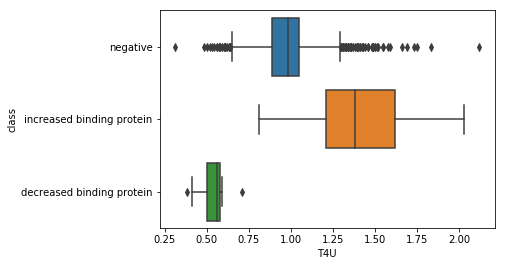

In [149]:
sns.boxplot('T4U', 'class', data=train_df)

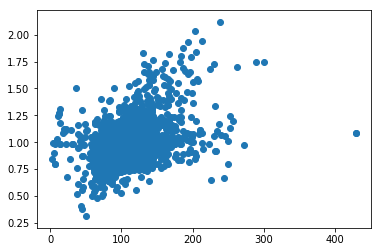

In [150]:
plt.scatter(train_df.TT4, train_df.T4U)

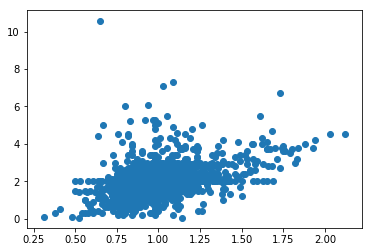

In [151]:
plt.scatter(train_df.T4U, train_df.T3)

### T4U

Zacnime najprv parametrom T4U.

### Definicie funkcii

In [152]:
def T4U_pred(df, arr):
    for i in range(len(df)):
        if (df[i] < 0.75):
            temp = 'decreased binding protein'
        elif (df[i] > 1.2):
            temp = 'increased binding protein'
        else:
            temp = 'negative'
        arr.append(temp)

In [153]:
def compare(df, arr):
    c = 0
    for i in range(len(df)):
        if (arr[i] != df[i]):
            print(i, ':', arr[i], ', ', df[i])
            c+=1
    print('pocet zlych odhadnuti: ', c)
    print('uspesnost ', 1 - c/len(df))

### 1. Dataset - hodnoty nahradene medianom

In [154]:
man_pred = []
T4U_pred(train_df['T4U'], man_pred)
print("Accuracy: ",accuracy_score(train_df['class'],man_pred))
print(classification_report(train_df['class'],man_pred,digits=5))

Accuracy:  0.8966442953020134
                           precision    recall  f1-score   support

decreased binding protein    0.09091   1.00000   0.16667         9
increased binding protein    0.38421   0.75258   0.50871        97
                 negative    0.98767   0.90277   0.94331      2129

                micro avg    0.89664   0.89664   0.89664      2235
                macro avg    0.48760   0.88512   0.53956      2235
             weighted avg    0.95787   0.89664   0.92132      2235



### 2. Dataset - hodnoty nahradene priemerom segmentu

In [155]:
man_pred2 = []
T4U_pred(train_df2['T4U'], man_pred2)
print("Accuracy: ",accuracy_score(train_df2['class'],man_pred2))
print(classification_report(train_df2['class'],man_pred2,digits=5))

Accuracy:  0.9328859060402684
                           precision    recall  f1-score   support

decreased binding protein    0.00000   0.00000   0.00000         9
increased binding protein    0.38421   0.75258   0.50871        97
                 negative    0.98386   0.94504   0.96406      2129

                micro avg    0.93289   0.93289   0.93289      2235
                macro avg    0.45602   0.56587   0.49092      2235
             weighted avg    0.95388   0.93289   0.94042      2235



/home/palo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/palo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/palo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Vidime, ze accuracy pri prvom datasete je 89% a pri druhom datasete je to 93%. Co sa tyka precision, to sme dosiahli vyssie pri prvom datasete a recall a f1-score je vyssie pri druhom datasete. Nie je to zle, skusme podmienku rozsirit o hodnotu TT4.

### T4U a TT4

### Definicie funkcii

In [156]:
def T4U_TT4_pred(dft4u,dftt4, arr):
    for i in range(len(dft4u)):
        if (dft4u[i] < 0.75 and dftt4[i] < 50):
            temp = 'decreased binding protein'
        elif (dft4u[i] > 1.2 and dftt4[i] > 200):
            temp = 'increased binding protein'
        else:
            temp = 'negative'
        arr.append(temp)

In [157]:
def compare(df, arr):
    c = 0
    for i in range(len(df)):
        if (arr[i] != df[i]):
            print(i, ':', arr[i], ', ', df[i])
            c+=1
    print('pocet zlych odhadnuti: ', c)
    print('uspesnost ', 1 - c/len(df))

### 1. Dataset - hodnoty nahradene medianom

In [158]:
man2_pred = []
T4U_TT4_pred(train_df['T4U'],train_df['TT4'], man2_pred)
print("Accuracy: ",accuracy_score(train_df['class'],man2_pred))
print(classification_report(train_df['class'],man2_pred,digits=5))

Accuracy:  0.9561521252796421
                           precision    recall  f1-score   support

decreased binding protein    0.66667   0.66667   0.66667         9
increased binding protein    0.69231   0.09278   0.16364        97
                 negative    0.95888   0.99671   0.97743      2129

                micro avg    0.95615   0.95615   0.95615      2235
                macro avg    0.77262   0.58539   0.60258      2235
             weighted avg    0.94613   0.95615   0.94086      2235



### 2. Dataset - hodnoty nahradene priemerom segmentu

In [159]:
man2_pred2 = []
T4U_TT4_pred(train_df2['T4U'],train_df2['TT4'], man2_pred2)
print("Accuracy: ",accuracy_score(train_df2['class'],man2_pred2))
print(classification_report(train_df2['class'],man2_pred2,digits=5))

Accuracy:  0.9525727069351231
                           precision    recall  f1-score   support

decreased binding protein    0.00000   0.00000   0.00000         9
increased binding protein    0.00000   0.00000   0.00000        97
                 negative    0.95257   1.00000   0.97571      2129

                micro avg    0.95257   0.95257   0.95257      2235
                macro avg    0.31752   0.33333   0.32524      2235
             weighted avg    0.90739   0.95257   0.92944      2235



/home/palo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/palo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/palo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Vidime, ze accuracy sa nam pri prvom datasete zvysilo o 6% a pri druhom datasete o 2%. Pri prvom datasete sa mierne znizilo precision, ale vyrazne stuplo recall a f1-score. Pri druhom datasete pozorujeme rovnaky jav. Skusme este pridat hodnotu T3.

### T4U, TT4 a T3

### Definicie funkcii

In [160]:
def T4U_TT4_T3_pred(dft4u, dftt4, dft3, arr):
    for i in range(len(dft4u)):
        if (dft4u[i] < 0.75 and dftt4[i] < 50 and dft3[i] < 1):
            temp = 'decreased binding protein'
        elif (dft4u[i] > 1.2 and dftt4[i] < 200 and dft3[i] > 3):
            temp = 'increased binding protein'
        else:
            temp = 'negative'
        arr.append(temp)

In [161]:
def compare(df, arr):
    c = 0
    for i in range(len(df)):
        if (arr[i] != df[i]):
            print(i, ':', arr[i], ', ', df[i])
            c+=1
    print('pocet zlych odhadnuti: ', c)
    print('uspesnost ', 1 - c/len(df))

### 1. Dataset - hodnoty nahradene medianom

In [162]:
man3_pred = []
T4U_TT4_T3_pred(train_df['T4U'],train_df['TT4'],train_df['T3'], man3_pred)
print("Accuracy: ",accuracy_score(train_df['class'],man3_pred))
print(classification_report(train_df['class'],man3_pred,digits=5))

Accuracy:  0.9619686800894854
                           precision    recall  f1-score   support

decreased binding protein    0.71429   0.55556   0.62500         9
increased binding protein    0.73684   0.28866   0.41481        97
                 negative    0.96667   0.99436   0.98032      2129

                micro avg    0.96197   0.96197   0.96197      2235
                macro avg    0.80593   0.61286   0.67338      2235
             weighted avg    0.95568   0.96197   0.95435      2235



### 2. Dataset - hodnoty nahradene priemerom segmentu

In [163]:
man3_pred2 = []
T4U_TT4_T3_pred(train_df2['T4U'],train_df2['TT4'],train_df2['T3'], man3_pred2)
print("Accuracy: ",accuracy_score(train_df2['class'],man3_pred2))
print(classification_report(train_df2['class'],man3_pred2,digits=5))

Accuracy:  0.9628635346756153
                           precision    recall  f1-score   support

decreased binding protein    0.00000   0.00000   0.00000         9
increased binding protein    0.72549   0.38144   0.50000        97
                 negative    0.96841   0.99342   0.98076      2129

                micro avg    0.96286   0.96286   0.96286      2235
                macro avg    0.56463   0.45829   0.49359      2235
             weighted avg    0.95396   0.96286   0.95594      2235



/home/palo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/palo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/palo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Vidime, ze opat nam stupli hodnoty accuracy. V pripade prveho datasetu je to o 0.5% a v pripade druheho o 1%. Takisto pri oboch datasetoch stupli aj hodnoty precision, recall aj f1-score. Postupnou optimalizaciou podmienok sme dosiahli celkom peknu uspesnost klasifikacie. Podme sa pozriet ako pojde klasifikacia rozhodovacim stromom.

## Rozhodovacie stromy

### 1. dataset - hodnoty nahradene medianom

In [164]:
train_df['class'].value_counts(normalize=True)

negative                     0.952573
increased binding protein    0.043400
decreased binding protein    0.004027
Name: class, dtype: float64

Najskor pouzijeme rozhodovaci strom s defaultne nastavenymi parametrami, ktore neskor budeme upravovat.

In [165]:
cls = DecisionTreeClassifier()
xTrain = train_df.select_dtypes([np.number])
yTrain = train_df['class']
xValid = valid_df.select_dtypes([np.number])
yValid = valid_df['class']
model = cls.fit(xTrain, yTrain)
cls_pred = model.predict(xValid)

cls.score(xTrain, yTrain)

1.0

Vidime, ze presnost na trenovacich datach je 100% a na validacnych o nieco mensia, priblizne 97%. Algoritmus sme vyhodnotili pomocou metrik accuracy, precision a recall. 

In [166]:
cls.score(xValid, yValid)

0.9660493827160493

In [167]:
print("Accuracy: ",accuracy_score(yValid,cls_pred))
print(classification_report(yValid,cls_pred,digits=5))

Accuracy:  0.9660493827160493
                           precision    recall  f1-score   support

decreased binding protein    0.60000   0.60000   0.60000         5
increased binding protein    0.44737   0.68000   0.53968        25
                 negative    0.98924   0.97558   0.98236       942

                micro avg    0.96605   0.96605   0.96605       972
                macro avg    0.67887   0.75186   0.70735       972
             weighted avg    0.97330   0.96605   0.96901       972



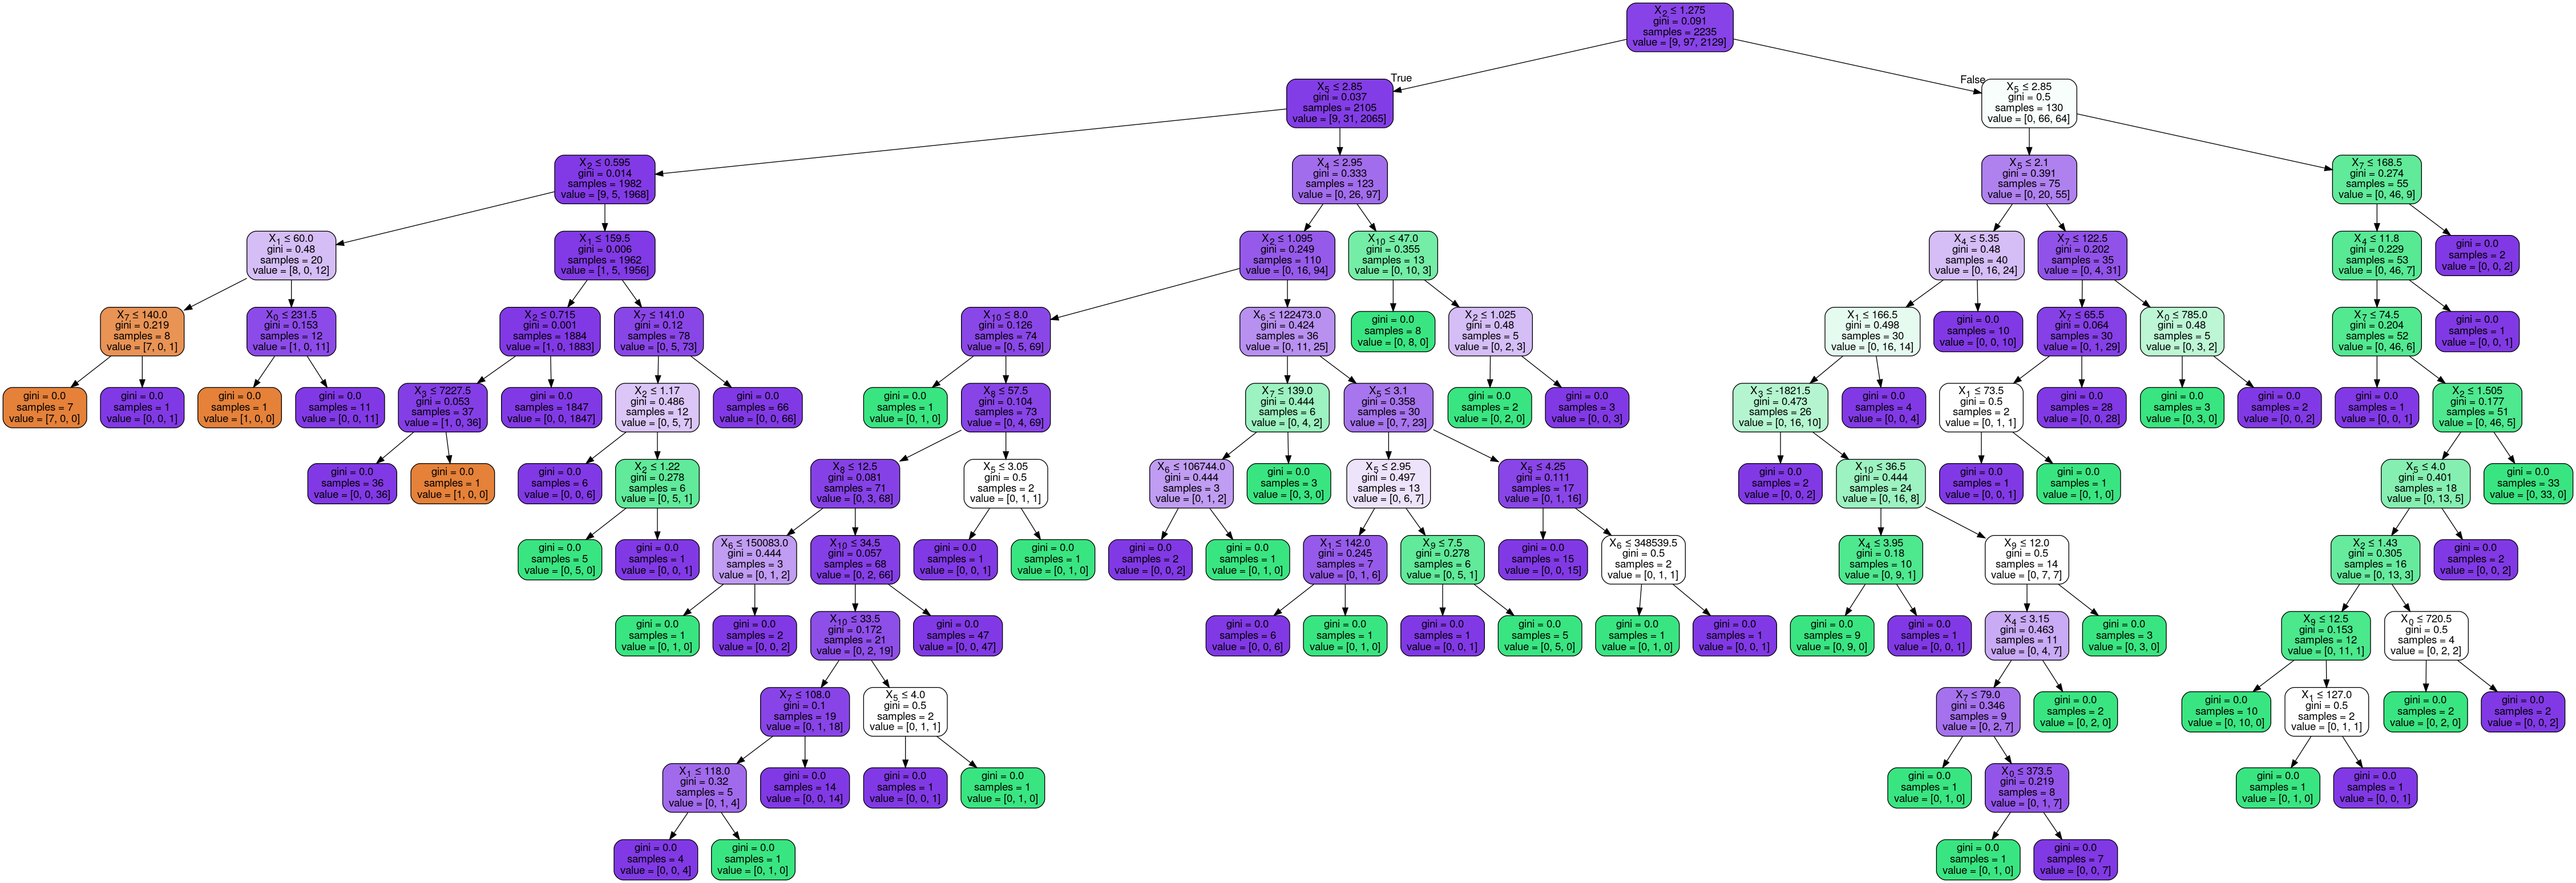

In [172]:
dot_data = StringIO()
export_graphviz(cls, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### 2. dataset - hodnoty nahradene priemerom segmentu

Opat pouzijeme rozhodovaci strom s defaultne nastavenymi parametrami, ktore neskor budeme upravovat.

In [169]:
cls2 = DecisionTreeClassifier()
xTrain2 = train_df2.select_dtypes([np.number])
yTrain2 = train_df2['class']
xValid2 = valid_df2.select_dtypes([np.number])
yValid2 = valid_df2['class']
model2 = cls2.fit(xTrain, yTrain)
cls2_pred = model2.predict(xValid)

cls2.score(xTrain2, yTrain2)

0.9829977628635347

In [170]:
cls2.score(xValid2, yValid2)

0.9588477366255144

In [171]:
print("Accuracy: ",accuracy_score(yValid2,cls2_pred))
print(classification_report(yValid2,cls2_pred,digits=5))

Accuracy:  0.9650205761316872
                           precision    recall  f1-score   support

decreased binding protein    0.66667   0.80000   0.72727         5
increased binding protein    0.42105   0.64000   0.50794        25
                 negative    0.98922   0.97452   0.98182       942

                micro avg    0.96502   0.96502   0.96502       972
                macro avg    0.69231   0.80484   0.73901       972
             weighted avg    0.97295   0.96502   0.96832       972



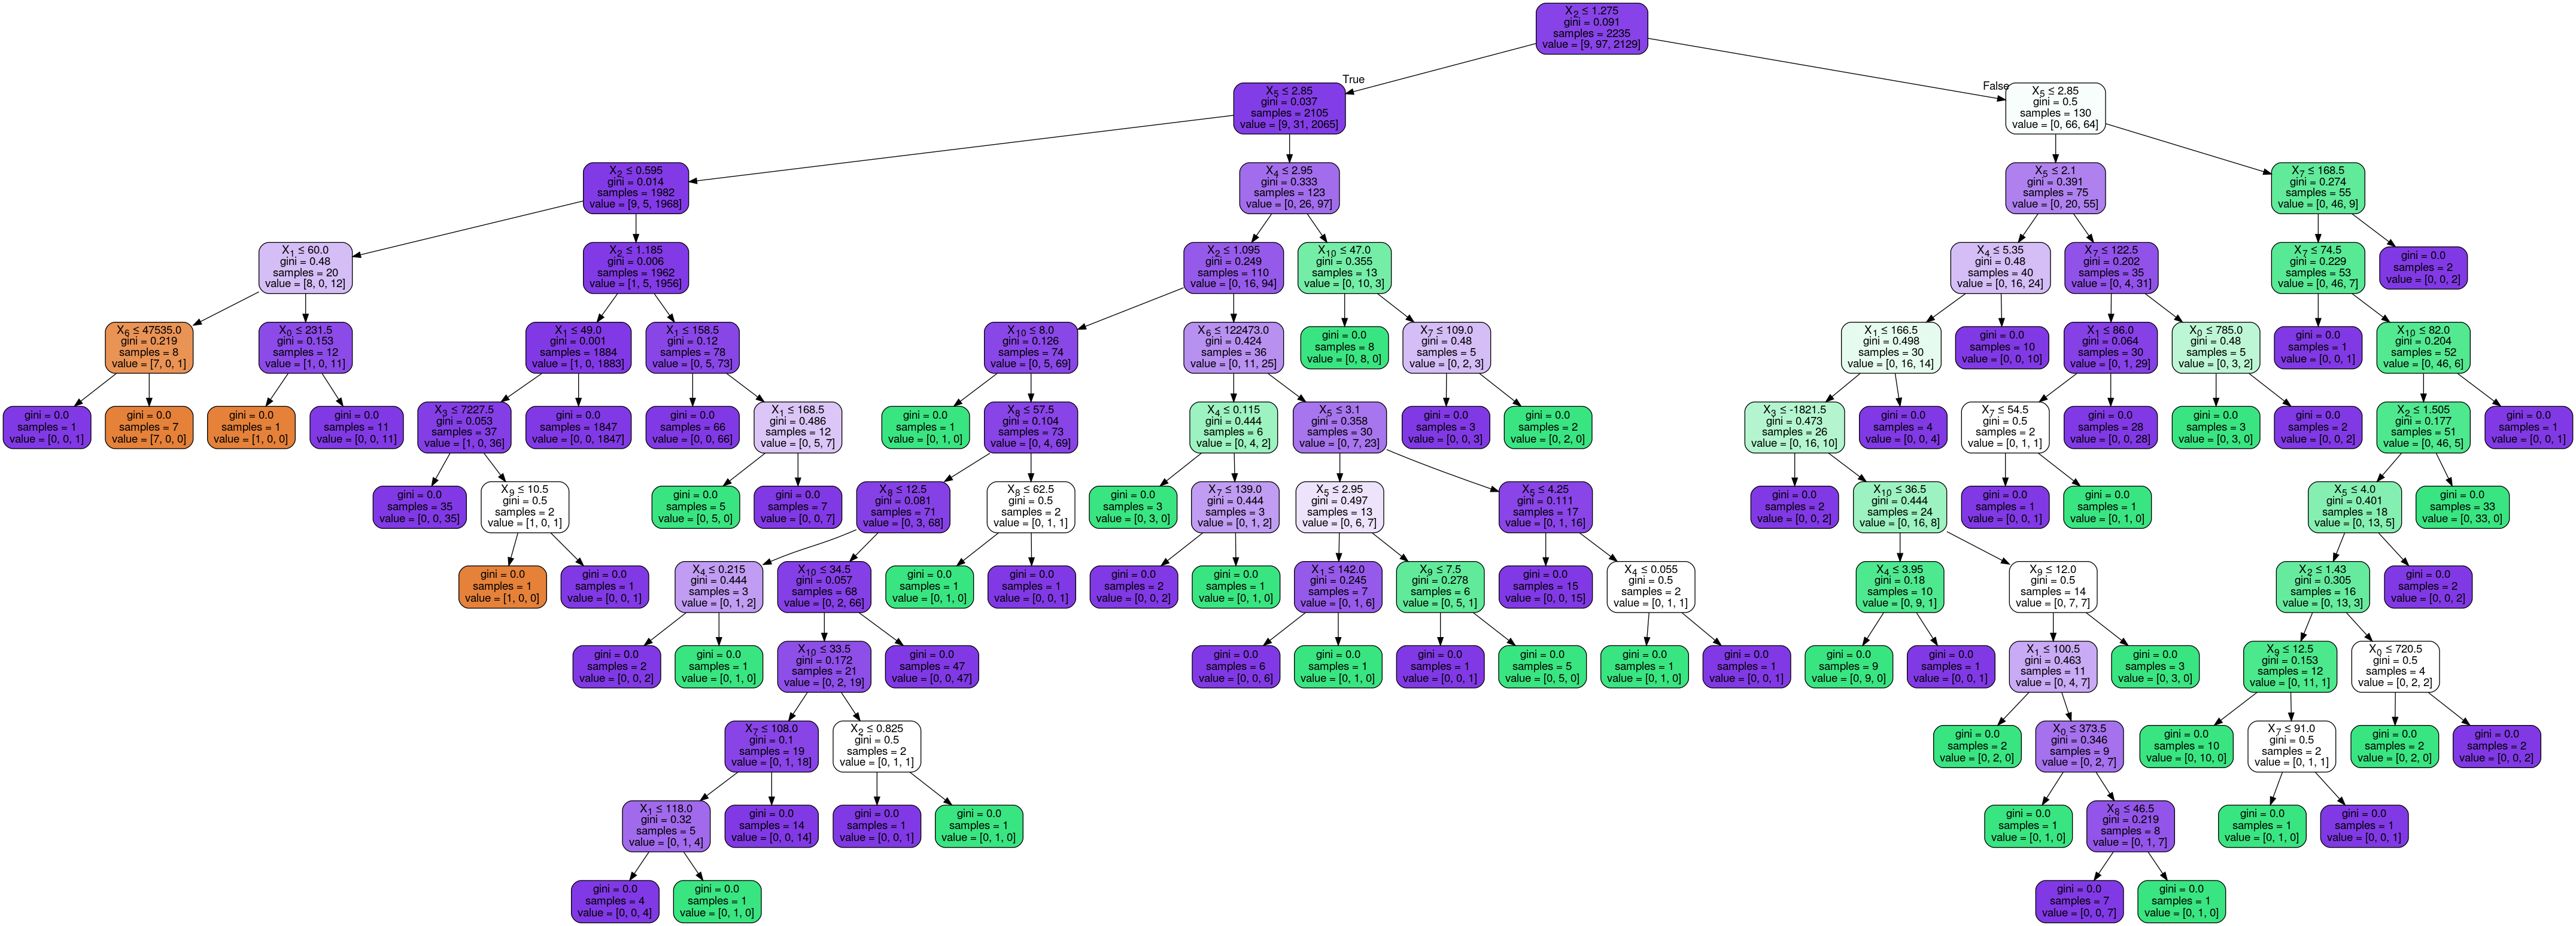

In [173]:
dot_data = StringIO()
export_graphviz(cls2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Nastavenie hyperparametrov

Zatial sme si vsimli, ze lepsie vysledky dosahujeme pri 1. datasete, kde sme nahradili chybajuce hodnoty medianom. Avsak, vidime ze rozhodovacie stromy s defaultnymi parametrami su dost komplexne a hlboke, cim riskujeme preucenie. Aby sme predisli preuceniu, nastavime rozhodovaciemu stromu optimalne parametre.

Ako parametre, ktore budeme menit sme si zvolili 'max_depth', 'criterion' a 'min_samples_leaf'. Pouzivame 10 nasobnu krizovu validaciu.

Parameter 'max_depth' urcuje maximalnu hlbku rozhodovacieho stromu, 'criterion' urcuje ktoru z funkcii pouzijeme (Gini impurity alebo Information Gain Entropy) a 'min_samples_leaf' urcuje minimalny pocet vzoriek na liste.

### 1. dataset - hodnoty nahradene medianom

In [174]:
cls_param = DecisionTreeClassifier
cv_params = {'max_depth': [1,2,3,4,5] + list(range(5,10,2)), 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3] }
ind_params = {'random_state': 0}
optimization = GridSearchCV(cls_param(**ind_params), 
                            cv_params, 
                            cv = 10, n_jobs = -1, verbose=True)
print(len(ParameterGrid(cv_params)))
list(ParameterGrid(cv_params))

48


[{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 2},
 {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 3},
 {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2},
 {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3},
 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2},
 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 3},
 {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2},
 {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3},
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2},
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3},
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_lea

In [175]:
optimization.fit(xTrain, yTrain)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/home/palo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    5.1s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 5, 7, 9], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [176]:
optimization.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [177]:
optimization.best_score_

0.9700223713646532

In [178]:
cls_optimal = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
cls_optimal.fit(xTrain, yTrain)
cls_optimal_pred=cls_optimal.predict(xValid)
cls_optimal.score(xTrain, yTrain)

0.9731543624161074

In [179]:
cls_optimal.score(xValid, yValid)

0.970164609053498

In [180]:
print("Accuracy: ",accuracy_score(yValid,cls_optimal_pred))
print(classification_report(yValid,cls_optimal_pred,digits=5))

Accuracy:  0.970164609053498
                           precision    recall  f1-score   support

decreased binding protein    0.00000   0.00000   0.00000         5
increased binding protein    0.51852   0.56000   0.53846        25
                 negative    0.98307   0.98620   0.98463       942

                micro avg    0.97016   0.97016   0.97016       972
                macro avg    0.50053   0.51540   0.50770       972
             weighted avg    0.96606   0.97016   0.96809       972



/home/palo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/palo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/palo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


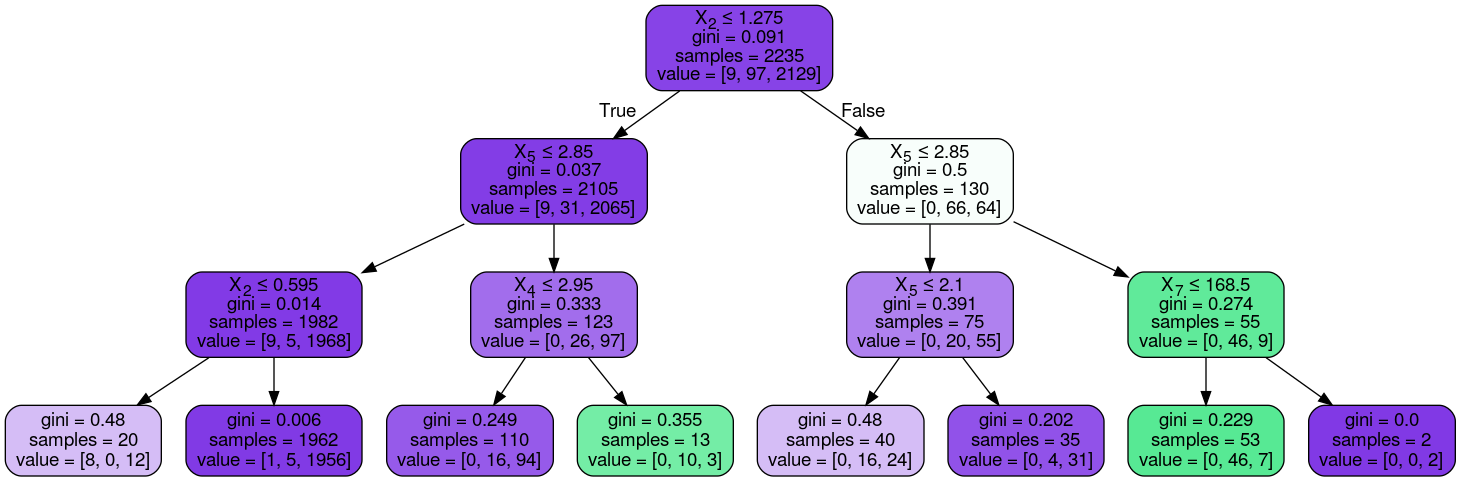

In [181]:
dot_data = StringIO()
export_graphviz(cls_optimal, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Optimalizovany strom je v porovnani s defaultnym stromom ovela jednoduchsi a dosahuje mensiu hlbku. O nieco vyssiu accuracy, recall a f1-score dosahujeme prave s optimalizovanym algoritmom. Hodnota precision je naopak o nieco nizsia.

### 2. dataset - hodnoty nahradene priemerom segmentu

In [182]:
cls2_param = DecisionTreeClassifier
cv_params = {'max_depth': [1,2,3,4,5] + list(range(5,10,2)), 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3] }
ind_params = {'random_state': 0}
optimization2 = GridSearchCV(cls2_param(**ind_params), 
                            cv_params, 
                            cv = 10, n_jobs = -1, verbose=True)
print(len(ParameterGrid(cv_params)))
list(ParameterGrid(cv_params))

48


[{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 2},
 {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 3},
 {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2},
 {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3},
 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2},
 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 3},
 {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2},
 {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3},
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2},
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3},
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_lea

In [183]:
optimization2.fit(xTrain2, yTrain2)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/home/palo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    2.6s finished
/home/palo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 5, 7, 9], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [184]:
optimization2.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [185]:
optimization2.best_score_

0.9686800894854586

In [186]:
cls2_optimal = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
cls2_optimal.fit(xTrain2, yTrain2)
cls2_optimal_pred=cls2_optimal.predict(xValid2)
cls2_optimal.score(xTrain2, yTrain2)

0.9686800894854586

In [187]:
cls2_optimal.score(xValid2, yValid2)

0.9732510288065843

In [188]:
print("Accuracy: ",accuracy_score(yValid2,cls2_optimal_pred))
print(classification_report(yValid2,cls2_optimal_pred,digits=5))

Accuracy:  0.9732510288065843
                           precision    recall  f1-score   support

decreased binding protein    0.00000   0.00000   0.00000         5
increased binding protein    0.59091   0.52000   0.55319        25
                 negative    0.98211   0.99045   0.98626       942

                micro avg    0.97325   0.97325   0.97325       972
                macro avg    0.52434   0.50348   0.51315       972
             weighted avg    0.96699   0.97325   0.97005       972



/home/palo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/palo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/palo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


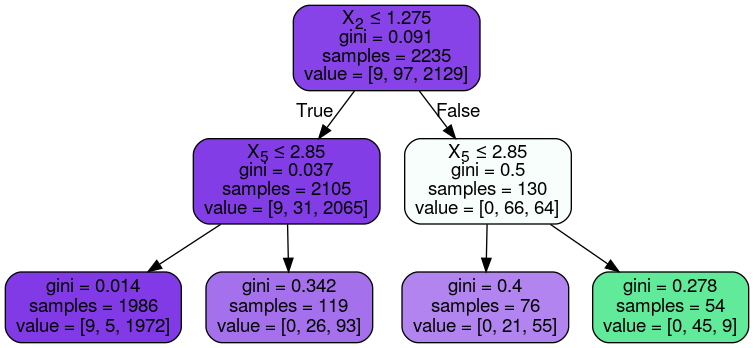

In [189]:
dot_data = StringIO()
export_graphviz(cls2_optimal, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Pri druhom datasete vidime este vyraznejsiu optimalizaciu. Vysledny strom ma hlbku iba 2 oproti povodnym 11 a zlepsenie vidime ako pri accuracy, tak aj pri recall a f1-score. Opat, hodnota precision je o nieco malo nizsia.

## Zaver

Pomocou manualne nastavenych parametrov pre klasifikaciu sme sa dokazali priblizit k celkom vysokej uspesnosti klasifikacie (accuracy). Dokonca sme dosiahli taku presnost, ze oproti rozhodovaciemu stromu s defaultnymi parametrami sme boli horsi iba v desatinach percenta:

* 1. dataset - manualne 96.2% / rozhodovaci strom 96.6%
* 2. dataset - manualne 96.2% / rozhodovaci strom 96.5%

Avsak, po uprave hyperparametrov rozhodovacieho stromu (kde sme vybrali najlepsie mozne parametre podla GridSearch), stupla jeho presnost pri prvom datasete na 97.0% a pri druhom datasete na 97.3%. 

Z uvedenych pozorovani takisto vyplyva, ze pre presnejsiu klasifikaciu je lepsie pouzit na dosadenie chybajucich hodnot priemer segmentu ako median.

Zaujimavym pozorovanim je, ze niektore algoritmy s vysokym accuracy vobec nepredikuju hodnotu 'decreased binding protein' a naopak algoritmy s nizsim accuracy tuto hodnotu predikuju. Dovodom je s najvacsou pravdepodonostou to, ze tychto hodnot je v datasete velmi malo, co by sa mozno dalo vyriesit oversamplingom.

Je teda na pouzivatelovi, ci mu zalezi na vyssej hodnote accuracy bez predikcie vsetkych hodnot, alebo predikcii vsetkych hodnot so znizenym accuracy.

## Predikovana hodnota testovacieho datasetu

Na predikciu hodnot v testovacom datasete vyuzijeme optimalizovany rozhodovaci strom na datach, kde sme chybajuce hodnoty doplnili priemerom segmentu, pretoze dosahuje najvyssiu accuracy.

In [211]:
xTest2 = test_df2.select_dtypes([np.number])
test_pred=cls2_optimal.predict(xTest2)

In [212]:
test_pred

array(['negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'increased binding protein',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'increased binding protein',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative